# On-line classification with the perceptron algorithm and a maximum margin approach


### Theoretical foundations of the Perceptron algorithm

The Perceptron algorithm, introduced by Rosenblatt in 1958, is one of the earliest and most well-known models of supervised learning. It was originally inspired by the way biological neurons process information, but can also be understood as a very simple linear classifier.

Given an input vector $ \mathbf{x} \in \mathbb{R}^n $ and a weight vector $ \mathbf{w} \in \mathbb{R}^n $, the prediction is computed as:

$$
\hat{y} = \text{sign}(\mathbf{w}^\top \mathbf{x})
$$

The algorithm works online: it goes through the training data one example at a time. If it makes a mistake (i.e. the predicted label doesn't match the true label), it updates the weight vector using the following rule:

$$
\mathbf{w}_{t+1} = \mathbf{w}_t + y_t \mathbf{x}_t \quad \text{if } y_t (\mathbf{w}_t^\top \mathbf{x}_t) \leq 0
$$

So every time the classifier mislabels a data point, the weights are adjusted in the direction that would have helped classify it correctly.

From a geometric perspective, the Perceptron tries to find a separating hyperplane that divides the two classes. This hyperplane is defined by the weight vector $ \mathbf{w} $, and a point is misclassified when it lies on the wrong side of that boundary.

One of the most important theoretical results is the **Perceptron Convergence Theorem**. It says that if the training data is linearly separable (i.e. a perfect hyperplane exists that separates the two classes), then the algorithm is guaranteed to find such a hyperplane in a finite number of updates. If there is a unit vector $ \mathbf{w}^* $ and a margin $ \gamma > 0 $ such that for all training points $ y_t (\mathbf{w}^* \cdot \mathbf{x}_t) \geq \gamma $, then the total number of updates $ M $ is bounded by:

$$
M \leq \left( \frac{R}{\gamma} \right)^2
$$

where $ R = \max_t \| \mathbf{x}_t \| $. This means that in the ideal case, learning will eventually stop, and the algorithm will converge.

However, in real-world situations data is often **noisy** or **not perfectly separable**. In these cases, the Perceptron doesn't converge and may keep updating forever. This is one of its main weaknesses and is exactly the motivation for improvements like the Passive-Aggressive algorithm, which is designed to be more stable in those non-separable scenarios.




### Explanation of Binary Classification with the Passive-Aggressive algorithm

While the classical Perceptron algorithm performs well on linearly separable data, it struggles in scenarios where the data is noisy or overlapping. In these cases, it can fail to converge and oscillate indefinitely, reacting strongly to every misclassified example, even if the error is due to label noise or ambiguity.

In the online learning setting described by Crammer et al. (2006), the learning algorithm receives a sequence of examples $(x_t, y_t)$, where $x_t \in \mathbb{R}^n$ is an input vector and $y_t \in \{-1, +1\}$ is the corresponding label. The learning algorithm maintains a linear classifier defined by a weight vector $w_t$, and makes predictions of the form $\hat{y}_t = \text{sign}(w_t \cdot x_t)$.

After making a prediction, the algorithm observes the true label and receives a loss if the prediction is wrong or not confident enough. Confidence is shown by the margin, defined as

$$
\gamma_t = y_t (w_t \cdot x_t).
$$

A prediction is considered confident if the margin is at least 1. The loss is measured using the hinge-loss function:

$$
\ell_t = \max(0, 1 - y_t (w_t \cdot x_t)).
$$

The Passive-Aggressive (PA) algorithm is based on the principle of updating the model only when necessary (i.e., when $\ell_t > 0$), and performing the minimal change required to enforce a margin of at least 1 on the current example. This leads to the following constrained optimization problem at each round $t$:

$$
w_{t+1} = \arg\min_{w \in \mathbb{R}^n} \frac{1}{2} \|w - w_t\|^2 \quad \text{subject to} \quad \ell(w; (x_t, y_t)) = 0.
$$

This formulation aims to keep the new weight vector $w_{t+1}$ as close as possible to the current $w_t$, while ensuring that the updated model correctly classifies the current example with a sufficient margin. The solution to this problem has a closed-form expression:

$$
w_{t+1} = w_t + \tau_t y_t x_t,
$$

where

$$
\tau_t = \frac{\ell_t}{\|x_t\|^2}.
$$

This update rule reflects the core idea of the PA algorithm: to remain passive when no correction is needed and to become aggressive when the margin constraint is violated, applying the smallest possible update that fixes the current mistake.



##Implementation of the algorithm

####Dataset

In this experiment, a synthetic 2D dataset is generated with two overlapping Gaussian clusters to simulate a non-separable scenario with label noise. This setup reflects realistic conditions where perfect separation is not possible.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import seaborn as sns


# Dataset noise and overlap
#Generates a 2D dataset with two overlapping Gaussian clusters (binary classes) and optional label noise.

def noisy_dataset(n_samples_per_class=700, noise_rate=0.25, seed=None):

    if seed is not None:
        np.random.seed(seed)

    # Class +1
    mean1 = [-1, -2]
    cov1 = [[1.2, 0.7], [0.7, 1.0]]
    X1 = np.random.multivariate_normal(mean1, cov1, n_samples_per_class)
    y1 = np.ones(n_samples_per_class)

    # Class -1
    mean2 = [1, 1]
    cov2 = [[1.2, -0.5], [-0.5, 1.0]]
    X2 = np.random.multivariate_normal(mean2, cov2, n_samples_per_class)
    y2 = -np.ones(n_samples_per_class)

    # Combine
    X = np.vstack((X1, X2))
    y = np.hstack((y1, y2))

    # Add moderate label noise
    flip_mask = np.random.rand(2 * n_samples_per_class) < noise_rate
    y[flip_mask] *= -1

    return X, y


####Perceptron and Passive Aggressive Algorithm implementation
Both algorithms use online updates: the Perceptron adjusts weights when a mistake occurs, while the Passive-Aggressive algorithm makes the smallest possible update to fix margin violations.


In [9]:
def predict(X, w):
    return np.sign(X @ w)

def train_perceptron(X, y):
    w = np.zeros(X.shape[1])
    updates_P = 0
    for t in range(len(X)):
        x_t = X[t]
        y_t = y[t]

        prediction = np.sign(np.dot(w, x_t))

        if y_t * prediction <= 0:
            w = w + y_t * x_t
            updates_P += 1

    return w, updates_P


def train_PassiveAgressive(X,y):
  w = np.zeros(X.shape[1])
  updates_PA = 0
  for t in range(len(X)):
    x_t=X[t]
    y_t=y[t]

    margin = y_t * np.dot(w, x_t)
    l_hinge = max(0, 1 - margin)

    if l_hinge > 0 and np.dot(x_t, x_t) > 0:
      tau = l_hinge / np.dot(x_t, x_t)
      w = w + tau * y_t * x_t
      updates_PA += 1

  return w, updates_PA


def train_PassiveAgressive_II(X, y, C=1.0):

    w = np.zeros(X.shape[1])
    updates_PA2 = 0

    for t in range(len(X)):
        x_t = X[t]
        y_t = y[t]

        margin = y_t * np.dot(w, x_t)
        l_hinge = max(0, 1 - margin)

        if l_hinge > 0 and np.dot(x_t, x_t) > 0:
            tau = l_hinge / (np.dot(x_t, x_t) + 1/(2*C))
            w = w + tau * y_t * x_t
            updates_PA2 += 1

    return w, updates_PA2


####Training and Evaluation

Both the Perceptron and the Passive-Aggressive algorithm are trained online on the same noisy data. The process is repeated for multiple random seeds to capture the variability in performance.
Additionaly their accuracies on a test set are recorded.
To illustrate the learned models, the decision boundaries are plotted for the last run. Additionally, the margin distributions on the test set are computed and visualized using histograms.

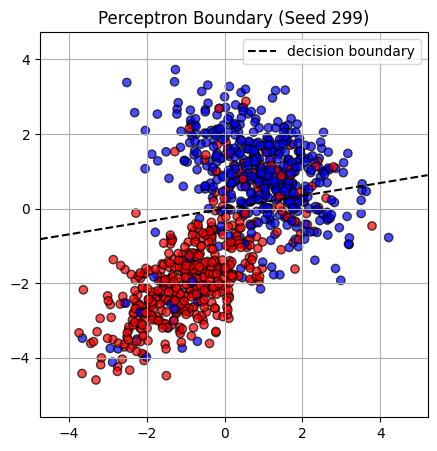

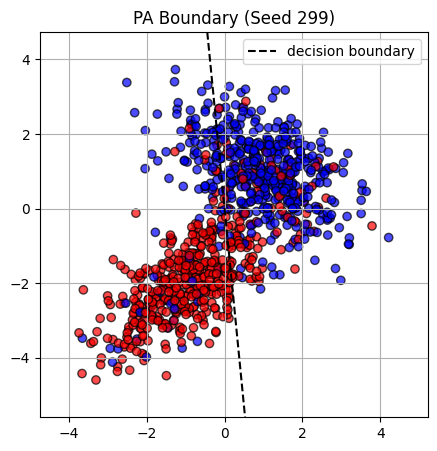


--- Accuracy summary over 300 seeds ---
Perceptron:
  Mean accuracy:            0.777
  Standard deviation:       0.17
Passive-Aggressive:
  Mean accuracy:            0.774
  Standard deviation:       0.175
Updates Perceptron (last seed): 227, PA: 386


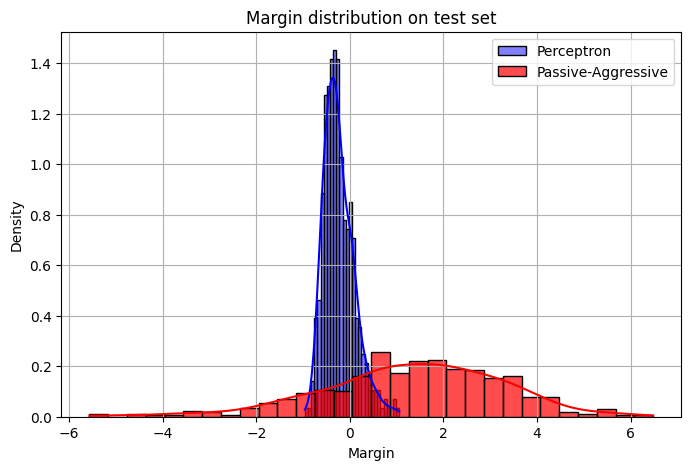

In [7]:
# decision boundary

def plot_decision_boundary(X, y, w, title):

    plt.figure(figsize=(5, 5))
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap="bwr", edgecolor="k", alpha=0.7)

    # Computation decision boundry line
    x_vals = np.array([X[:, 0].min() - 1, X[:, 0].max() + 1])
    if w[1] != 0:
        y_vals = -(w[0] / w[1]) * x_vals
        plt.plot(x_vals, y_vals, '--k', label='decision boundary')
    else:
        plt.axvline(x=0, color='k', linestyle='--')

    plt.title(title)
    plt.grid(True)
    plt.legend()
    plt.xlim(X[:, 0].min() - 1, X[:, 0].max() + 1)
    plt.ylim(X[:, 1].min() - 1, X[:, 1].max() + 1)
    plt.show()


#Training

n_seeds = 300
acc_P_list = []
acc_PA_list = []

for seed in range(n_seeds):
    # Generate noisy dataset with fixed overlap and noise level
    X, y = noisy_dataset(n_samples_per_class=700, noise_rate=0.1, seed=seed)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=seed)

    # Train Perceptron
    w_p, updates_p = train_perceptron(X_train, y_train)
    acc_p = np.mean(predict(X_test, w_p) == y_test)
    acc_P_list.append(acc_p)

    # Train Passive-Aggressive
    w_pa, updates_pa = train_PassiveAgressive(X_train, y_train)
    acc_pa = np.mean(predict(X_test, w_pa) == y_test)
    acc_PA_list.append(acc_pa)


    # Plot decision boundaries for the last seed
    if seed == n_seeds - 1:
        plot_decision_boundary(X_train, y_train, w_p, f"Perceptron Boundary (Seed {seed})")
        plot_decision_boundary(X_train, y_train, w_pa, f"PA Boundary (Seed {seed})")


#Evaluation

print("\n--- Accuracy summary over", n_seeds, "seeds ---")
print("Perceptron:")
print("  Mean accuracy:           ", np.round(np.mean(acc_P_list), 3))
print("  Standard deviation:      ", np.round(np.std(acc_P_list), 3))

print("Passive-Aggressive:")
print("  Mean accuracy:           ", np.round(np.mean(acc_PA_list), 3))
print("  Standard deviation:      ", np.round(np.std(acc_PA_list), 3))

print(f"Updates Perceptron (last seed): {updates_p}, PA: {updates_pa}")


# Margin density

def compute_margins(X, y, w):
    margins = y_test * (X_test @ w)
    return margins


# Compute margins on the same test set
margins_P = compute_margins(X_test, y_test, w_p)
margins_PA = compute_margins(X_test, y_test, w_pa)

# Histogram

plt.figure(figsize=(8,5))
sns.histplot(margins_P, bins=30, color='blue', label='Perceptron', kde=True, stat="density")
sns.histplot(margins_PA, bins=30, color='red', label='Passive-Aggressive', kde=True, stat="density", alpha=0.7)
plt.xlabel("Margin")
plt.ylabel("Density")
plt.title("Margin distribution on test set")
plt.legend()
plt.grid(True)
plt.show()

####Results Interpretation
The results show that both the Perceptron and the Passive-Aggressive algorithm achieve very similar mean accuracies on the noisy binary classification task, with average values around 77.7% and comparable standard deviations. This indicates that, despite their different update strategies, both models handle the given data with similar effectiveness in terms of raw classification performance.

A notable difference appears in the number of updates required during training: the Passive-Aggressive algorithm performs significantly more updates than the standard Perceptron. This reflects the algorithms idea: it does not only correct mistakes but also enforces a larger margin by adjusting the weights even when a prediction is correct but too close to the decision boundary.

This behaviour is also visible in the margin distribution on the test set. While the Perceptron’s margins cluster around zero, the Passive-Aggressive classifier shifts the margins towards higher positive values and shows a broader spread. This suggests that the Passive-Aggressive model achieves more confident classifications by pushing data points further from the boundary. However, because the dataset contains label noise, this increased aggressiveness does not lead to a notable improvement in test accuracy within the current training setup.

In summary, the Passive-Aggressive algorithm behaves as expected by widening the margin and making more updates. Although both methods reach similar accuracy, the larger margins produced by the Passive-Aggressive algorithm can be an advantage in practice. With additional training epochs and especially when applied to new, unseen data, the wider margin may lead to better generalization and increased robustness against misclassifications near the decision boundary.

####PA II

In [10]:
w_pa2, updates_pa2 = train_PassiveAgressive_II(X_train, y_train, C=1.0)
acc_pa2 = np.mean(predict(X_test, w_pa2) == y_test)
print("  Mean accuracy:           ", np.round(np.mean(acc_pa2), 3))

  Mean accuracy:            0.814
  Standard deviation:       0.0



To see if the Passive-Aggressive algorithm can be improved, I also tested the PA-II variant described by Crammer et al. (2006). The only difference to the standard PA (also called PA-I) is the calculation of the update step size
τ. While PA uses $\tau = \frac{L}{\|x\|^2}$, PA-II adds a regularization parameter
C and computes
$$
\tau = \frac{L}{\|x\|^2 + \frac{1}{2C}}.
$$

This means the update is softer and does not overreact to noisy points. In my experiment, PA-II reached a mean accuracy of about 0.814, which is higher than both PA and the Perceptron. This shows that the regularization helps the model to generalize better on noisy data, because it prevents the weight vector from changing too much for single mistakes. This effect matches what Crammer et al. showed in their paper.
